# Lab 3 — Vehicle Data Analysis and Visualization
Assignement Overview- 
You have been tasked by a company to analyze and process data related to vehicles from
previous years. Your role involves extracting key statistical insights from the dataset and
visualizing the data to uncover patterns and trends. This project will test your ability to work
with real-world data, apply statistical methods, and create informative visualizations.

In [54]:
#1 imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

#matplotlib config for notebook display
plt.rcParams.update({'figure.figsize': (10,6)})


In [56]:
#2 Read dataset

df = pd.read_csv('vehicles_data.csv', encoding='ISO-8859-1', low_memory=False)
print('Loaded dataframe with shape:', df.shape)
print('Columns:', list(df.columns))

#normalize the column names for safer access
orig_cols = list(df.columns)
col_map = {c.strip().lower().replace(' ', '_').replace('.', '').replace('-', '_'): c for c in orig_cols}
col_map


Loaded dataframe with shape: (803889, 13)
Columns: ['Date Of Stop', 'Time Of Stop', 'Description', 'Location', 'VehicleType', 'Year', 'Make', 'Model', 'Color', 'Violation Type', 'Race', 'Gender', 'Price']


{'date_of_stop': 'Date Of Stop',
 'time_of_stop': 'Time Of Stop',
 'description': 'Description',
 'location': 'Location',
 'vehicletype': 'VehicleType',
 'year': 'Year',
 'make': 'Make',
 'model': 'Model',
 'color': 'Color',
 'violation_type': 'Violation Type',
 'race': 'Race',
 'gender': 'Gender',
 'price': 'Price'}

# 3 Identifying columns

Look for the columns we need: `Year`, `Price`/`Prices`, `Make`, and `VehicleType`.

Renaming columns

In [58]:
#3 Identify canonical columns and coerce numeric types

def find_col(possible_names):
    for p in possible_names:
        kp = p.strip().lower().replace(' ', '_').replace('.', '').replace('-', '_')
        if kp in col_map:
            return col_map[kp]
    return None

year_col = find_col(['Year','year','vehicle_year'])
price_col = find_col(['Prices','Price','price','estimated_price'])
make_col = find_col(['Make','make','manufacturer'])
vehicle_type_col = find_col(['VehicleType','Vehicle_type','vehicle_type','Vehicle Type','Vehicle type'])

print('Detected mapping:')
print(' year_col =', year_col)
print(' price_col =', price_col)
print(' make_col =', make_col)
print(' vehicle_type_col =', vehicle_type_col)

#rename to canonical short names if found
if year_col:
    df = df.rename(columns={year_col: 'Year'})
if price_col:
    df = df.rename(columns={price_col: 'Prices'})
if make_col:
    df = df.rename(columns={make_col: 'Make'})
if vehicle_type_col:
    df = df.rename(columns={vehicle_type_col: 'VehicleType'})

#convert Year and Prices to numeric when possible
if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
if 'Prices' in df.columns:
    df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')

print('\nCanonical columns present now:', [c for c in ['Year','Prices','Make','VehicleType'] if c in df.columns])


Detected mapping:
 year_col = Year
 price_col = Price
 make_col = Make
 vehicle_type_col = VehicleType

Canonical columns present now: ['Year', 'Prices', 'Make', 'VehicleType']


# 4. Raw statistics (before cleaning)

Compute the requested raw values: 6th newest and 4th oldest based on the `Year` column, and count missing values.

These are raw — without cleaning

In [62]:
#raw analysis
missing_per_col = df.isnull().sum()
total_missing = int(missing_per_col.sum())

#6th newest (raw)
df_years = df.dropna(subset=['Year']).sort_values(by='Year', ascending=False).reset_index(drop=True)
raw_6th_newest = df_years.loc[5] if len(df_years) >= 6 else None

#4th oldest (raw)
df_years_asc = df.dropna(subset=['Year']).sort_values(by='Year', ascending=True).reset_index(drop=True)
raw_4th_oldest = df_years_asc.loc[3] if len(df_years_asc) >= 4 else None

print('Total missing values (raw):', total_missing)
print('\nRaw 6th newest (if present):')
print(raw_6th_newest if raw_6th_newest is not None else 'Not enough non-NA Year rows')
print('\nRaw 4th oldest (if present):')
print(raw_4th_oldest if raw_4th_oldest is not None else 'Not enough non-NA Year rows')


Total missing values (raw): 26250

Raw 6th newest (if present):
Date Of Stop                                                 4/9/14
Time Of Stop                                               16:56:00
Description       PARENT KNOWINGLY PERMIT MINOR TO VIOLATE BICYC...
Location                          5501 NICHOLSON LANE, BETHESDA, MD
VehicleType                                              28 - Other
Year                                                         9999.0
Make                                                             99
Model                                                            99
Color                                                           NaN
Violation Type                                             Citation
Race                                                          WHITE
Gender                                                            F
Prices                                                    3202402.0
Name: 5, dtype: object

Raw 4th oldest (if present):

# 5. Data cleaning 

Cleaning data to remove void/placeholder values:

- Keep `Year` only if `1900 <= Year <= 2025` (otherwise set to `NaN`).
- Treat `Make` entries that are numeric or short numeric-like placeholders (like `'99'`) as `NaN`.

In [65]:
#apply cleaning
clean_df = df.copy()

#year: mark out-of-range years as NaN
current_year_limit = 2025
clean_df.loc[(clean_df['Year'] < 1900) | (clean_df['Year'] > current_year_limit), 'Year'] = np.nan

#make: treat numeric makes or placeholder like makes as NaN
if 'Make' in clean_df.columns:
    #consider a Make invalid if it is numeric when stripped, or if it consists of only 1-3 digits
    def clean_make(x):
        try:
            if pd.isna(x):
                return x
            s = str(x).strip()
            if s.isdigit():
                return np.nan
            #treat '99' or '999' etc as invalid, and entries like '0' or '00'
            if len(s) <= 3 and any(ch.isdigit() for ch in s) and not any(ch.isalpha() for ch in s):
                return np.nan
            return s
        except Exception:
            return np.nan
    clean_df['Make'] = clean_df['Make'].apply(clean_make)

#recompute missing totals after cleaning
missing_per_col_clean = clean_df.isnull().sum()
total_missing_clean = int(missing_per_col_clean.sum())

#cleaned 6th newest and 4th oldest
cd_years_desc = clean_df.dropna(subset=['Year']).sort_values(by='Year', ascending=False).reset_index(drop=True)
clean_6th_newest = cd_years_desc.loc[5] if len(cd_years_desc) >= 6 else None
cd_years_asc = clean_df.dropna(subset=['Year']).sort_values(by='Year', ascending=True).reset_index(drop=True)
clean_4th_oldest = cd_years_asc.loc[3] if len(cd_years_asc) >= 4 else None

print('Total missing values (after cleaning):', total_missing_clean)
print('\nCleaned 6th newest:')
print(clean_6th_newest if clean_6th_newest is not None else 'Not enough non-NA Year rows')
print('\nCleaned 4th oldest:')
print(clean_4th_oldest if clean_4th_oldest is not None else 'Not enough non-NA Year rows')


Total missing values (after cleaning): 27334

Cleaned 6th newest:
Date Of Stop                                                 5/9/15
Time Of Stop                                               22:20:00
Description       FAILURE TO DISPLAY TWO LIGHTED FRONT LAMPS WHE...
Location                                      RT 355 / EDMONSTON DR
VehicleType                                         02 - Automobile
Year                                                         2023.0
Make                                                           NISS
Model                                                        SENTRA
Color                                                         BLACK
Violation Type                                              Warning
Race                                                       HISPANIC
Gender                                                            M
Prices                                                      11513.0
Name: 5, dtype: object

Cleaned 4th oldest:
Date O

# 6. Build findings dataframe and save to CSV

include both raw and clean versions

In [67]:
#build findings table
findings = []

#helper to extract minimal info from a Series row
def row_to_dict(sr):
    if sr is None:
        return None
    d = {}
    for k in ['Year','Prices','Make','Model']:
        if k in sr.index:
            try:
                d[k] = sr[k]
            except Exception:
                d[k] = None
    return d

findings.append({'metric': 'raw_6th_newest', 'year': int(raw_6th_newest['Year']) if raw_6th_newest is not None and pd.notna(raw_6th_newest['Year']) else None,
                 'price': float(raw_6th_newest['Prices']) if raw_6th_newest is not None and 'Prices' in raw_6th_newest and pd.notna(raw_6th_newest['Prices']) else None,
                 'details': row_to_dict(raw_6th_newest)})

findings.append({'metric': 'raw_4th_oldest', 'year': int(raw_4th_oldest['Year']) if raw_4th_oldest is not None and pd.notna(raw_4th_oldest['Year']) else None,
                 'price': float(raw_4th_oldest['Prices']) if raw_4th_oldest is not None and 'Prices' in raw_4th_oldest and pd.notna(raw_4th_oldest['Prices']) else None,
                 'details': row_to_dict(raw_4th_oldest)})

findings.append({'metric': 'raw_total_missing', 'year': None, 'price': None, 'details': {'total_missing': int(total_missing)}})

findings.append({'metric': 'clean_6th_newest', 'year': int(clean_6th_newest['Year']) if clean_6th_newest is not None and pd.notna(clean_6th_newest['Year']) else None,
                 'price': float(clean_6th_newest['Prices']) if clean_6th_newest is not None and 'Prices' in clean_6th_newest and pd.notna(clean_6th_newest['Prices']) else None,
                 'details': row_to_dict(clean_6th_newest)})

findings.append({'metric': 'clean_4th_oldest', 'year': int(clean_4th_oldest['Year']) if clean_4th_oldest is not None and pd.notna(clean_4th_oldest['Year']) else None,
                 'price': float(clean_4th_oldest['Prices']) if clean_4th_oldest is not None and 'Prices' in clean_4th_oldest and pd.notna(clean_4th_oldest['Prices']) else None,
                 'details': row_to_dict(clean_4th_oldest)})

findings.append({'metric': 'clean_total_missing', 'year': None, 'price': None, 'details': {'total_missing': int(total_missing_clean)}})

findings_df = pd.DataFrame(findings)
findings_df.to_csv('findings.csv', index=False)
findings_df


,metric,year,price,details
0,raw_6th_newest,9999.0,3202402.0,"{'Year': 9999.0, 'Prices': 3202402.0, 'Make': ..."
1,raw_4th_oldest,0.0,500.0,"{'Year': 0.0, 'Prices': 500.0, 'Make': 'TOYOTA..."
2,raw_total_missing,NaN,NaN,{'total_missing': 26250}
3,clean_6th_newest,2023.0,11513.0,"{'Year': 2023.0, 'Prices': 11513.0, 'Make': 'N..."
4,clean_4th_oldest,1900.0,500.0,"{'Year': 1900.0, 'Prices': 500.0, 'Make': 'UNK..."
5,clean_total_missing,NaN,NaN,{'total_missing': 27334}


# 7. Visualizations
Create at least five unique graphs.

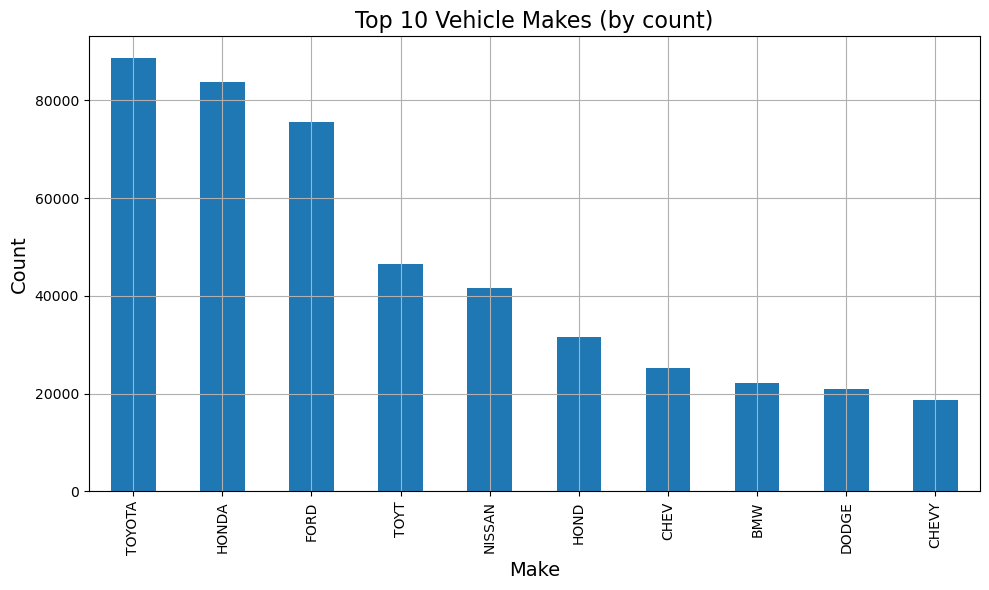

In [85]:
#1) Bar chart: Top 10 Makes by count (if Make exists)
if 'Make' in clean_df.columns:
    top_makes = clean_df['Make'].dropna().astype(str).value_counts().head(10)
    if not top_makes.empty:
        ax = top_makes.plot(kind='bar')
        ax.set_title('Top 10 Vehicle Makes (by count)', fontsize=16)
        ax.set_xlabel('Make', fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.grid(True)
        plt.tight_layout()
        plt.savefig("Bar_Chart.png")
        plt.show()
        plt.close()

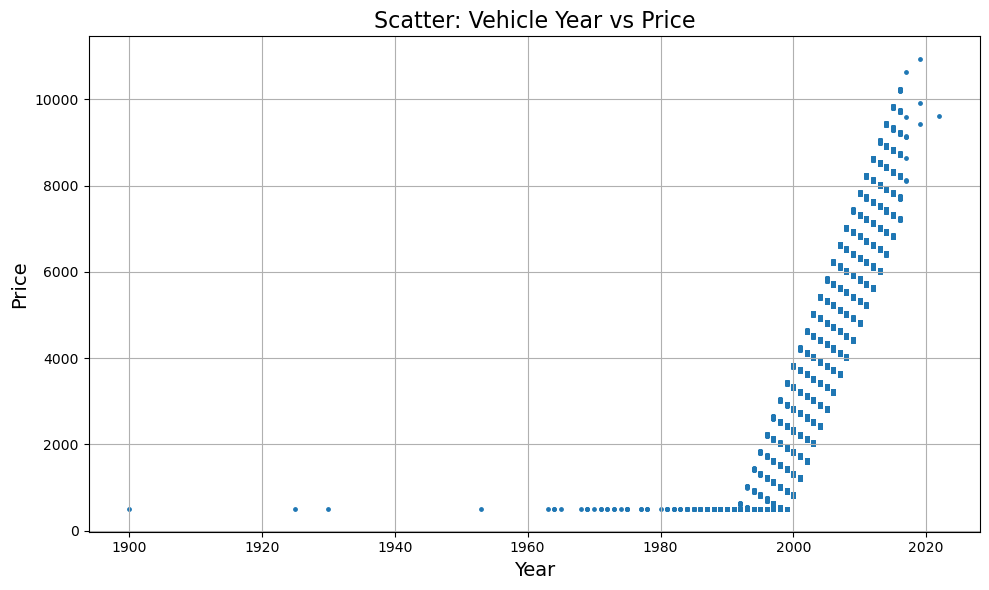

In [87]:
#2) Scatter: Year vs Price
if 'Year' in clean_df.columns and 'Prices' in clean_df.columns:
    pair = clean_df.dropna(subset=['Year','Prices'])
    if len(pair) > 0:
        sample = pair.sample(n=min(40000, len(pair)), random_state=1)
        plt.figure(figsize=(10,6))
        plt.scatter(sample['Year'], sample['Prices'], s=6)
        plt.title('Scatter: Vehicle Year vs Price', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Price', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("Scatter_Plot.png")
        plt.show()
        plt.close()

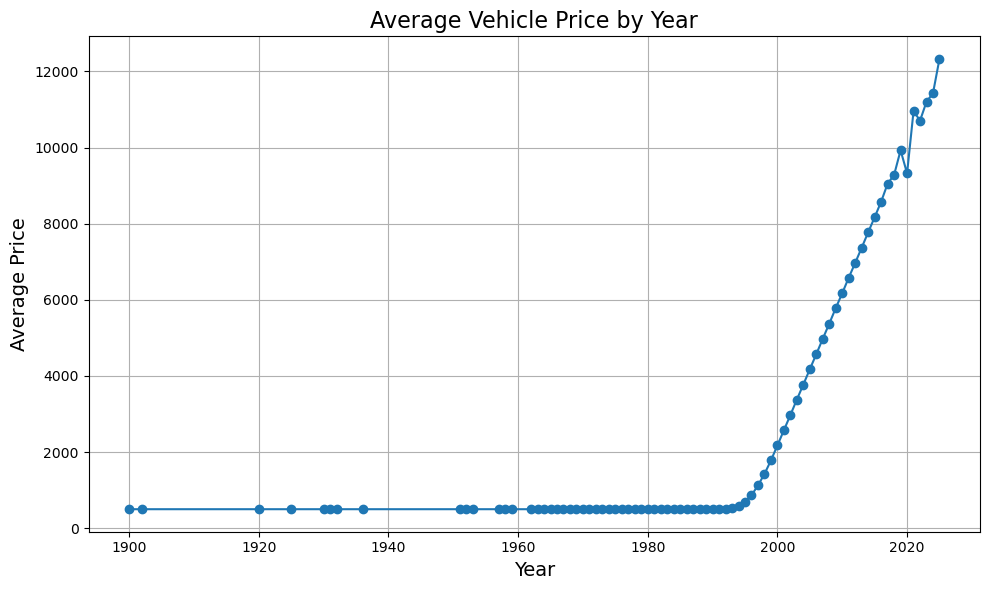

In [89]:
#3) Line: Average Price by Year
if 'Year' in clean_df.columns and 'Prices' in clean_df.columns:
    agg = clean_df.dropna(subset=['Year','Prices']).groupby('Year')['Prices'].mean().sort_index()
    if len(agg) > 0:
        plt.figure(figsize=(10,6))
        plt.plot(agg.index, agg.values, marker='o')
        plt.title('Average Vehicle Price by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Average Price', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("Avg_Vehicle_Price_by_Year.png")
        plt.show()
        plt.close()

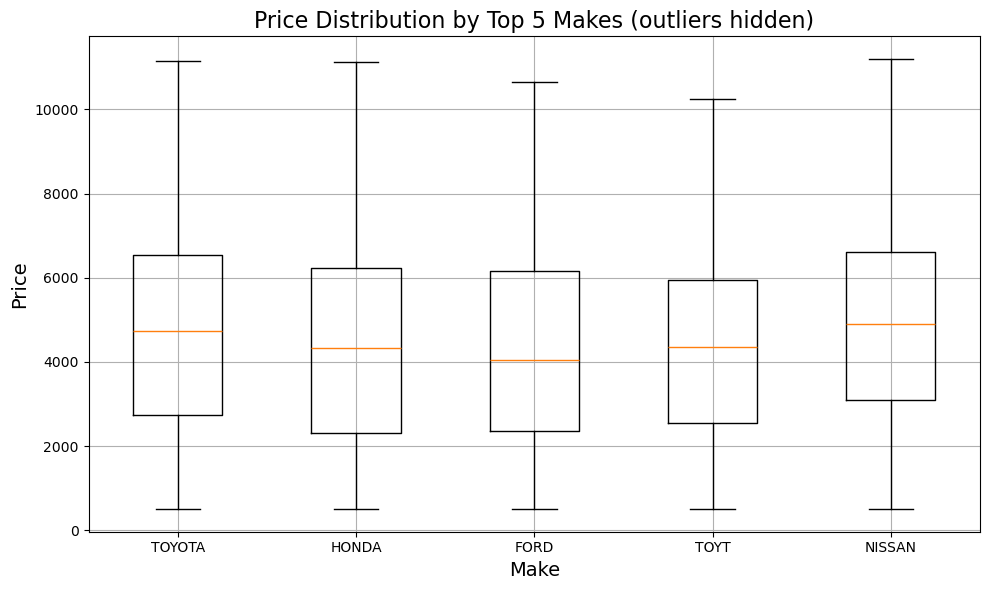

In [91]:
# 4) Boxplot: Price distribution for top 5 Makes
if 'Make' in clean_df.columns and 'Prices' in clean_df.columns:
    top5 = clean_df['Make'].dropna().astype(str).value_counts().head(5).index.tolist()
    box_data = [clean_df[clean_df['Make']==mk]['Prices'].dropna().values for mk in top5 if len(clean_df[clean_df['Make']==mk]['Prices'].dropna())>0]
    labels = [mk for mk in top5 if len(clean_df[clean_df['Make']==mk]['Prices'].dropna())>0]
    if box_data:
        plt.figure(figsize=(10,6))
        plt.boxplot(box_data, labels=labels, showfliers=False)
        plt.title('Price Distribution by Top 5 Makes (outliers hidden)', fontsize=16)
        plt.xlabel('Make', fontsize=14)
        plt.ylabel('Price', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("Price_Boxplot_Top5_makes.png")
        plt.show()
        plt.close()

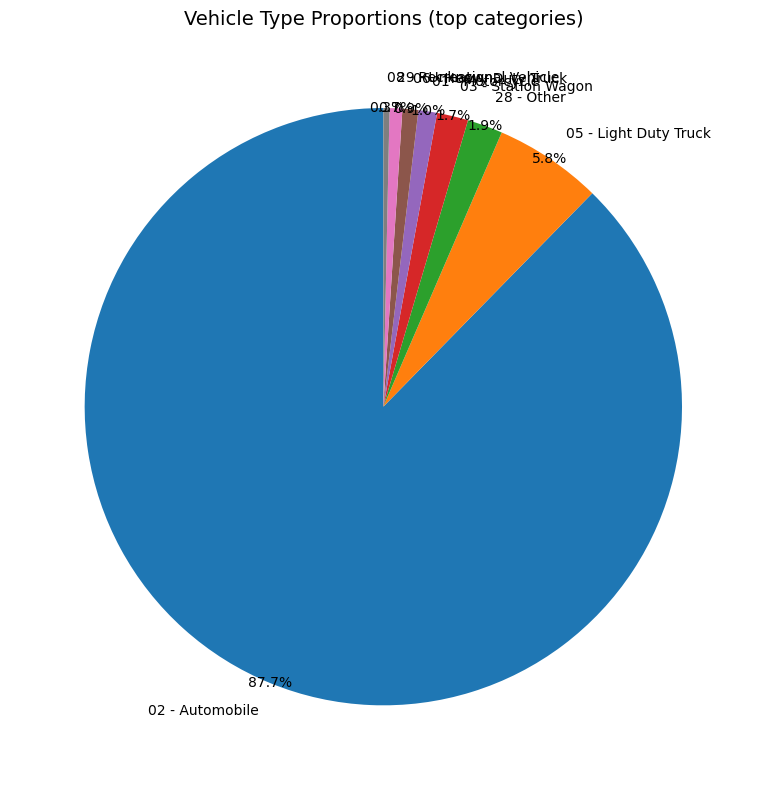

In [93]:
# 5) Pie chart: Vehicle type proportions (if VehicleType exists)
if 'VehicleType' in clean_df.columns:
    vt = clean_df['VehicleType'].dropna().astype(str).value_counts().head(8)
    if not vt.empty:
        plt.figure(figsize=(8,8))
        plt.pie(vt.values, labels=vt.index, autopct='%1.1f%%', pctdistance=1,startangle=90)
        plt.title('Vehicle Type Proportions (top categories)', fontsize=14)
        plt.tight_layout()
        plt.savefig("Vehicle_Type_PieChart.png")
        plt.show()
        plt.close()